<div style="font-weight: bold; color:#5D8AA8" align="center">
    <div style="font-size: xx-large">Natural Language Processing 2021-22</div><br>
    <div style="font-size: x-large; color:gray">Aspect opinion extraction</div><br>
    <div style="font-size: large">María Barroso - Gloria del Valle</div><br></div><hr>
</div>

In [1]:
#!python3 -m spacy download en_core_web_sm

In [219]:
import json
import pandas as pd
from IPython.display import display


import loader as LD
import manager as MG
import opinion_lexicon as OP
import aspect_opinion as AO
import plot_aspect_opinion as PAO


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<div style="font-weight: bold; color:#5D8AA8" align="center">    
    <div style="font-size: x-large; color:#5D8AA8">Review datasets</div><br>
</div>

First, a JSON file `yelp_hotels.json` containing 5,034 reviews generated by 4,148 Yelp users about 284 hotels  will be loaded. Then, two additional JSON files will also be uploaded: `yelp_beauty_spas.json` and `yelp_restaurants.json` which contain Yelp reviews about beauty/spa resorts and restaurants. These files will be loaded line by line.

Each review (JSON record) has the following fields:
* `reviewerID`: the identifier of the user who wrote the review
* `asin`: the identifier of the reviewed hotel
* `reviewText`: the text of the user’s review about the hotel
* `overall`: the 1-5 Likert scale rating assigned by the user to the hotel


In [3]:
reviews_hotels = LD.load_all_json_yelp('yelp_hotels')

yelp_hotels: 5034 reviews loaded


We show a row example from this dataset.

In [4]:
print(json.dumps(reviews_hotels[0], indent=2))

{
  "reviewerID": "qLCpuCWCyPb4G2vN-WZz-Q",
  "asin": "8ZwO9VuLDWJOXmtAdc7LXQ",
  "summary": "summary",
  "reviewText": "Great hotel in Central Phoenix for a stay-cation, but not necessarily a place to stay out of town and without a car. Not much around the area, and unless you're familiar with downtown, I would rather have a guest stay in Old Town Scottsdale, etc. BUT if you do stay here, it's awesome. Great boutique rooms. Awesome pool that's happening in the summer. A GREAT rooftop patio bar, and a very very busy lobby with Gallo Blanco attached. A great place to stay, but have a car!",
  "overall": 4.0
}


In [5]:
reviews_spas = LD.load_by_line_json_yelp('yelp_beauty_spas')

yelp_beauty_spas: 5580 reviews loaded


In [6]:
print(json.dumps(reviews_spas[0], indent=2))

{
  "reviewerID": "Xm8HXE1JHqscXe5BKf0GFQ",
  "asin": "WGNIYMeXPyoWav1APUq7jA",
  "summary": "summary",
  "reviewText": "Good tattoo shop. Clean space, multiple artists to choose from and books of their work are available for you to look though and decide who's style most mirrors what you're looking for. I chose Jet to do a cover-up for me and he worked with me on the design and our ideas and communication flowed very well. He's a very personable guy, is friendly and keeps the conversation going while he's working on you, and he doesn't dick around (read: He starts to work and continues until the job is done). He's very professional and informative. Good customer service combines with talent at the craft.",
  "overall": 4.0
}


In [7]:
reviews_restaurants = LD.load_by_line_json_yelp('yelp_restaurants')

yelp_restaurants: 158431 reviews loaded


In [8]:
print(json.dumps(reviews_restaurants[0], indent=2))

{
  "reviewerID": "rLtl8ZkDX5vH5nAx9C3q5Q",
  "asin": "9yKzy9PApeiPPOUJEtnvkg",
  "summary": "summary",
  "reviewText": "My wife took me here on my birthday for breakfast and it was excellent. The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure. Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning. It looked like the place fills up pretty quickly so the earlier you get here the better.Do yourself a favor and get their Bloody Mary. It was phenomenal and simply the best I've ever had. I'm pretty sure they only use ingredients from their garden and blend them fresh when you order it. It was amazing.While EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious. It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete. It was the best \"toast\" I've ever had.Anyway, I can't wait to go back!",

<div style="font-weight: bold; color:#5D8AA8" align="center">    
    <div style="font-size: x-large; color:#5D8AA8">Aspect vocabularies</div><br>
</div>



Next, vocabulary of the `aspects_hotels.csv` file will be loaded and printed on screen. Later, it will be used to identify aspect references in the reviews. In particular, the aspects terms will be mapped by exact matching with nouns appearing in the reviews.



In [9]:
aspects_hotels = LD.load_aspects('aspects_hotels')

We show an example of values returning from this aspects.

In [10]:
aspects_hotels.get('amenities')

['amenities', 'services']

In order to extend the lists of terms, synonyms of each aspect will be extracted from **WordNet** and included in our aspect vocabularies.

In [11]:
aspects_hotels = MG.extend_aspects(aspects_hotels)

We show an example of values returning from this aspects.

In [12]:
aspects_hotels.get('amenities')

['amenity',
 'creature_comforts',
 'comforts',
 'services',
 'agreeableness',
 'amenities',
 'conveniences']

Now, the same loading and vocabulary extension will be done for `aspects_spas.csv` and `aspects_restaurants.csv` files.

In [13]:
aspects_spas = LD.load_aspects('aspects_spas')
aspects_spas = MG.extend_aspects(aspects_spas)
aspects_spas.get('atmosphere')

['atmosphere',
 'music',
 'ambiances',
 'lighting',
 'ambiance',
 'ambience',
 'atmospheres',
 'light',
 'ambiences',
 'atm',
 'standard_atmosphere',
 'standard_pressure',
 'aura',
 'atmospheric_state',
 'air',
 'lights']

In [14]:
aspects_restaurants = LD.load_aspects('aspects_restaurants')
aspects_restaurants = MG.extend_aspects(aspects_restaurants)
aspects_restaurants.get('appetizers')

['appetizers',
 'entree',
 'starters',
 'appetizer',
 'starter',
 'appetiser',
 'entrees']

<div style="font-weight: bold; color:#5D8AA8" align="center">    
    <div style="font-size: x-large; color:#5D8AA8">Opinion Lexicon</div><br>
</div>

To extract the polarity of the aspect opinions that will be analyzed in the next section, different accessible opinion lexicons will be used:
- **SentiWordNet**
- **Boosters modifiers** (NTLK Vader sentiment opinion module)
- **modifier.csv** 
- **SentimentIntensityAnalyzer** (NLTK sentiment module)

Two main functions have been implemented to quantify the polarity of a sentence: `get_polarity_score` and `get_polarity` in **opinion_lexicon.py**. The latter only returns discrete polarity values {-1, 0, 1} for negative, neutral, and positive sentences, respectively.

The function `get_polarity_score` follows the next steps:

- Tokenize each sentence
- Create tagged element sets with each word
- Keep only the words with noun tags, adjectives tag and adverbs tag and discard all others.
- If is a modifier of **Constant Vader** or is in **modifier.csv**, boost the score having into account that if the modifier is negative, the polarity sign is changed automatically.
- If is not a modifier, compute the compound value given by `polarity_scores` of **SentimentIntensityAnalyzer**. If the score is 0.0, compute the difference between the positive and the negative score of the word using `senti_synset` function of the **SentiWordNet** module. Finally boost the total score having into account that if the current score is negative, the polarity sign is changed automatically.


Before performing the polarity analysis of the hotel reviews, we will test the implemented functions for different proposed phrases.

In [16]:
sentences = [
    'The hotel staff was very friendly',
    'The hotel staff was too friendly',
    'The hotel staff was much less friendly'
]

for sentence in sentences:
    polarity = OP.get_polarity_score(sentence)
    print(f'{sentence} : {polarity:.2f}')

The hotel staff was very friendly : 1.13
The hotel staff was too friendly : -1.48
The hotel staff was much less friendly : -2.12


In [17]:
sentences = [
    'a funny joke',
    'a quite funny joke',
    'a very funny joke',
    'a not very funny joke',
    'a not funny joke',
    'it is a funny joke',
    'i do not think it is a funny joke',
    'a too funny joke'
]

for sentence in sentences:
    polarity = OP.get_polarity_score(sentence)
    print(f'{sentence} : {polarity:.2f}')

a funny joke : 0.56
a quite funny joke : 0.59
a very funny joke : 0.59
a not very funny joke : -0.63
a not funny joke : -0.59
it is a funny joke : 0.56
i do not think it is a funny joke : -0.59
a too funny joke : -0.69


<div style="font-weight: bold; color:#5D8AA8" align="center">    
    <div style="font-size: x-large; color:#5D8AA8">Aspect opinions</div><br>
</div>
 
 
Once the aspect vocabulary and opinion lexicons are loaded, the opinions about aspects will be extracted from the reeviews.

For this purpose, the dependency parser of the **Stanford CoreNLP Java toolkit** allow us extracting the relations between nouns and adjectives and adverbs.

The function `get_aspect_opinion` from **aspect_opinion.py** module returns the `[aspect, opinion_word, aspect_term, polarity]` tuples from an input review. This tuples are computed using a rule based code from the dependency parser for each aspect included in the aspect dictionary loaded before. To compute de polarity the function `get_polarity` explained before is called for a sentence with the `opinion_word` and `aspect_term`.


The next examples shows the different tuples from each input review.

In [19]:
idx = 0
review = reviews_hotels[idx].get("reviewText")
print('Review:', review)
overall = reviews_hotels[idx].get("overall")
print('Rating:', overall)


data = AO.get_aspect_opinion(idx, review, aspects_hotels)
display(data)

Review: Great hotel in Central Phoenix for a stay-cation, but not necessarily a place to stay out of town and without a car. Not much around the area, and unless you're familiar with downtown, I would rather have a guest stay in Old Town Scottsdale, etc. BUT if you do stay here, it's awesome. Great boutique rooms. Awesome pool that's happening in the summer. A GREAT rooftop patio bar, and a very very busy lobby with Gallo Blanco attached. A great place to stay, but have a car!
Rating: 4.0


,aspect,opinion_word,aspect_term,polarity
review_id,,,,
0,SHOPPING,great,boutique rooms,1.0
0,POOL,awesome,pool,1.0
0,BAR,great,rooftop patio bar,1.0
0,BUILDING,very very busy,lobby,1.0


As we can see, we get information about SHOPPING, POOL, BAR and BUILDING and it achieves good results. All of the aspect returned are positive. However, the opinion word "very very busy" of the aspect term "lobby" should be a negative opinion and our polarity function does not work correctly because it is not domain dependent. Another limitation of our implementation is that it fails to return hidden aspects such as LOCATION and TRANSPORTATION.

Another example will be show from a random review.

In [20]:
idx = 20
review = reviews_hotels[idx].get("reviewText")
print('Review:', review)
overall = reviews_hotels[idx].get("overall")
print('Rating:', overall)


data = AO.get_aspect_opinion(idx, review, aspects_hotels)
display(data)

Review: We had a wonderful four nights at Gainey Ranch. The rooms were beautifully appointed (although not enough drawer space), immaculate, and high quality bath products, bed linens and furniture. We had a 3rd floor garden view, which was very Zen with a natural pond and fountain, and access to their Regency Club (a must have). The spa was very nice and they carry high quality products. They also have so many options to hang by a pool, including a private spa mineral pool (sans children). We understand there is a great kids pool also. The food was delicious at their restaurant also.We did not experience any construction issues (as they may be finished), but we certainly benefited from all their efforts. It is beautifully appointed and plenty of spaces that feel private. It is not a convention-like hotel, but I have heard (from a corporate event planner) they do a wonderful job for large parties. Everyone from the valet, to registration, housekeeping and wait staff were more than acco

,aspect,opinion_word,aspect_term,polarity
review_id,,,,
20,LOCATION,3rd,floor garden view,1.0
20,POOL,natural,pond,1.0
20,SPA,very nice,spa,1.0
20,SPA,private,spa mineral pool sans children,-1.0
20,POOL,great,kids pool,1.0
20,CUISINE,also delicious,food,1.0
20,EVENTS,corporate,event,1.0
20,STAFF,more,housekeeping staff,1.0
20,STAFF,general,manager,1.0


In this review, we can see a lot of aspect opinions. The only bad annotated is the one that corresponds to "private" spa. Due to the fact that the private spa has a negative connotation. 

A last example will be shown choosen with negative opinions.

In [21]:
idx = 800
review = reviews_hotels[idx].get("reviewText")
print('Review:', review)
overall = reviews_hotels[idx].get("overall")
print('Rating:', overall)


data = AO.get_aspect_opinion(idx, review, aspects_hotels)
display(data)

Review: Extremely disappointed with this place. Friends recommended it, but I certainly will not. We both ordered short rib chile rellenos but neither one of us could find ANY meat in our dish. Very limited wine list and very poor service. Our waiter delivered the food but then disappeared and we had to ask a bus boy to find him to get our check. No water refills, no asking how everything was, no asking if we would like another drink, he was just gone! When we asked where the meat had been he didn't apologize or offer to find out what happened. Lovely patio setting is the only reason I am giving it two stars. Oh, and small $15 margaritas - - - come on, really? First time my extremely generous tipping husband left no tip at all. Certainly not a Four Seasons caliber restaurant.
Rating: 2.0


,aspect,opinion_word,aspect_term,polarity
review_id,,,,
800,DRINKS,very limited,wine list,-1.0
800,SERVICE,very poor,service,-1.0
800,BUILDING,lovely only,reason patio setting,1.0


As we can see, for this review all the aspects are collected and polarized correctly.

<div style="font-weight: bold; color:#5D8AA8" align="center">    
    <div style="font-size: x-large; color:#5D8AA8">Opinion summarization</div><br>
</div>


Finally, to validate and evaluate the solutions implemented in previous tasks, all aspect opinions for all reviews will be saved. 

In [23]:
total_data = pd.DataFrame(columns = ['aspect', 'opinion_word', 'aspect_term', 'polarity'])
for idx in range(len(reviews_hotels)):
    review = reviews_hotels[idx].get("reviewText")
    data = AO.get_aspect_opinion(idx, review, aspects_hotels)
    total_data = total_data.append(data)

KeyboardInterrupt: 

Now, given an aspect, a summary of the aspect opinions will be visualized on screen.

In [220]:
aspect = 'STAFF'
data_aspect = total_data[total_data['aspect']==aspect].rename_axis('review_id')
data_aspect.head()

,aspect,opinion_word,aspect_term,polarity
review_id,,,,
2,STAFF,very courteous,staff,1.0
2,STAFF,very nice,staff,1.0
5,STAFF,personable attentive,staff,1.0
5,STAFF,grumpy uncooperative disinterested,staff,1.0
8,STAFF,probably friendliest,staff,1.0


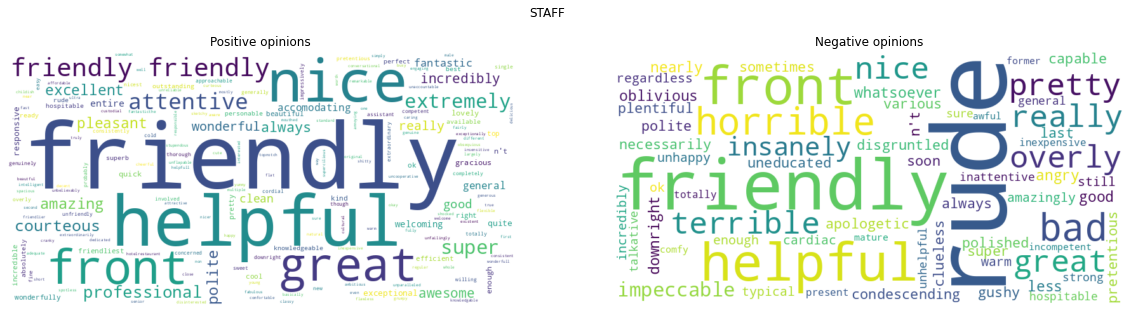

In [221]:
PAO.compute_cloud_opinion_word(data_aspect, aspect)

We can see in the cloud word the main positive and negative adjetives and modifiers found. In the negative cloud some positive words appear. This may be because we are only representing the polarity of the entire opinion and not of each word encountered.

Now, we will do the same for the first five aspects.

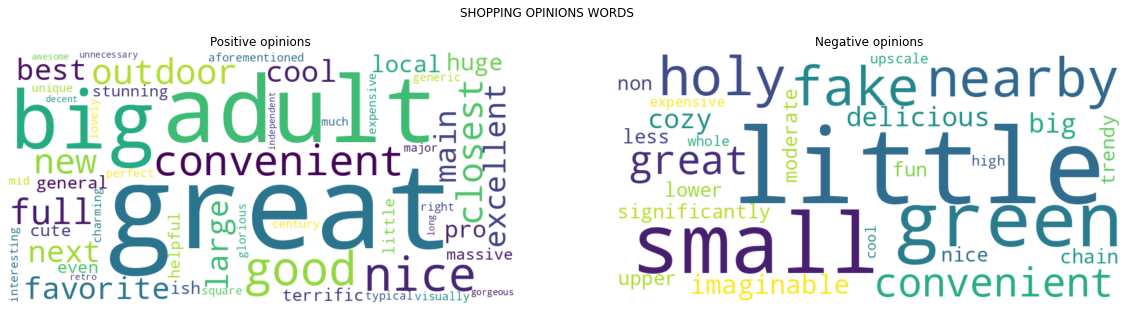

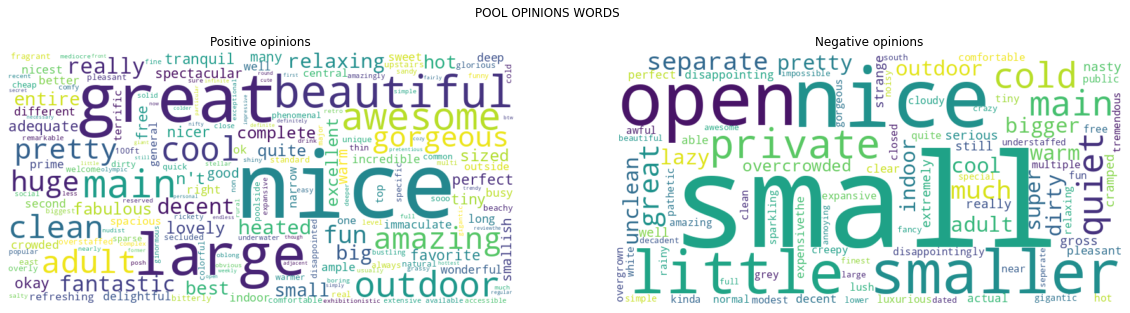

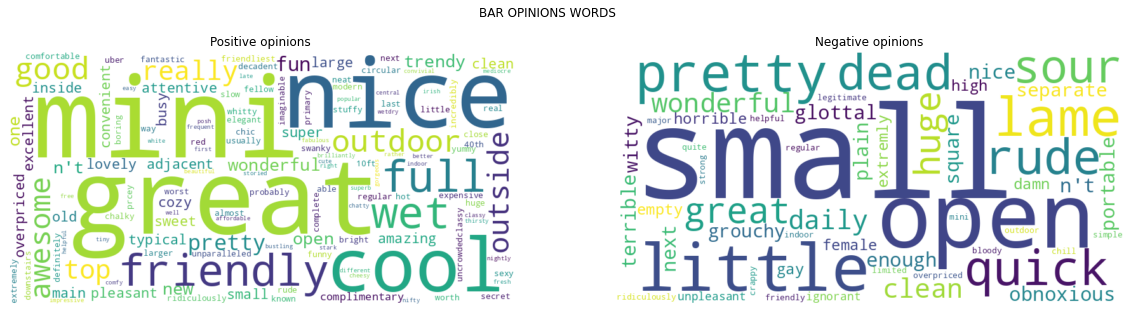

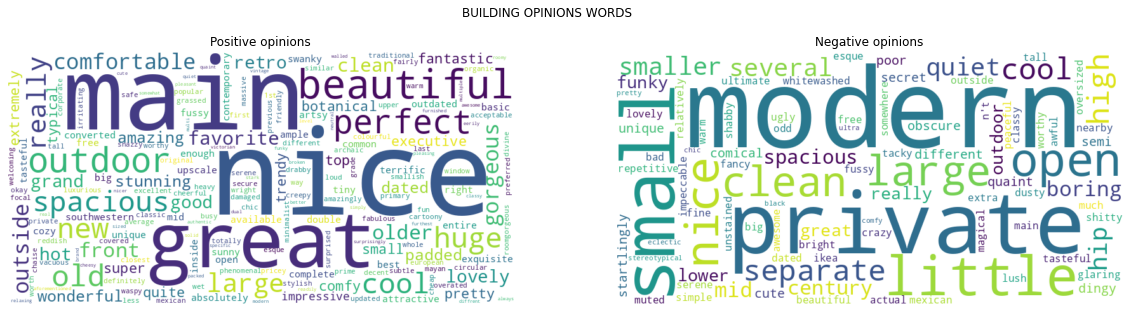

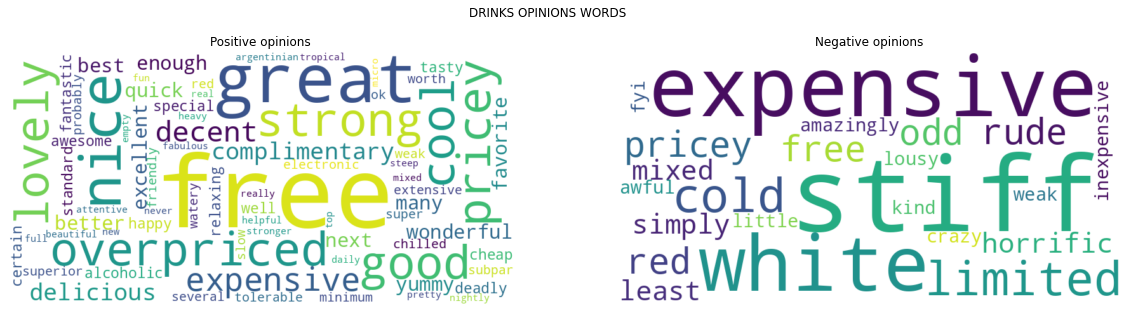

In [234]:
total_aspects = list(total_data.aspect.unique())[:5]
for aspect in total_aspects:
    data_aspect = total_data[total_data['aspect']==aspect].rename_axis('review_id')
    PAO.compute_cloud_opinion_word(data_aspect, aspect)

Now, the total number of positive/negative opinions for each aspect of the item will be visualized.

In [232]:
df_aspect = total_data.groupby(['aspect','polarity']).size().reset_index(name='total_review').set_index('aspect')
df_aspect_polarity = df_aspect.pivot_table(values='total_review', index=df_aspect.index, columns='polarity', aggfunc='first')
df_aspect_polarity = df_aspect_polarity.rename(columns={-1.0: "neg", 1.0: "pos"}).fillna(0)
display(df_aspect_polarity.T)

aspect,AMENITIES,ATMOSPHERE,BAR,BATHROOMS,BEDROOMS,BOOKING,BREAKFAST,BUILDING,CHECKING,CLEANLINESS,...,POOL,PRICE,RESTAURANT,RESTROOMS,SERVICE,SHOPPING,SPA,STAFF,TEMPERATURE,TRANSPORTATION
polarity,,,,,,,,,,,,,,,,,,,,,
neg,7.0,57.0,59.0,125.0,134.0,5.0,53.0,125.0,48.0,16.0,...,151.0,83.0,25.0,3.0,122.0,38.0,25.0,77.0,7.0,17.0
pos,30.0,205.0,216.0,437.0,525.0,15.0,524.0,475.0,71.0,31.0,...,558.0,257.0,144.0,5.0,614.0,74.0,112.0,875.0,14.0,119.0


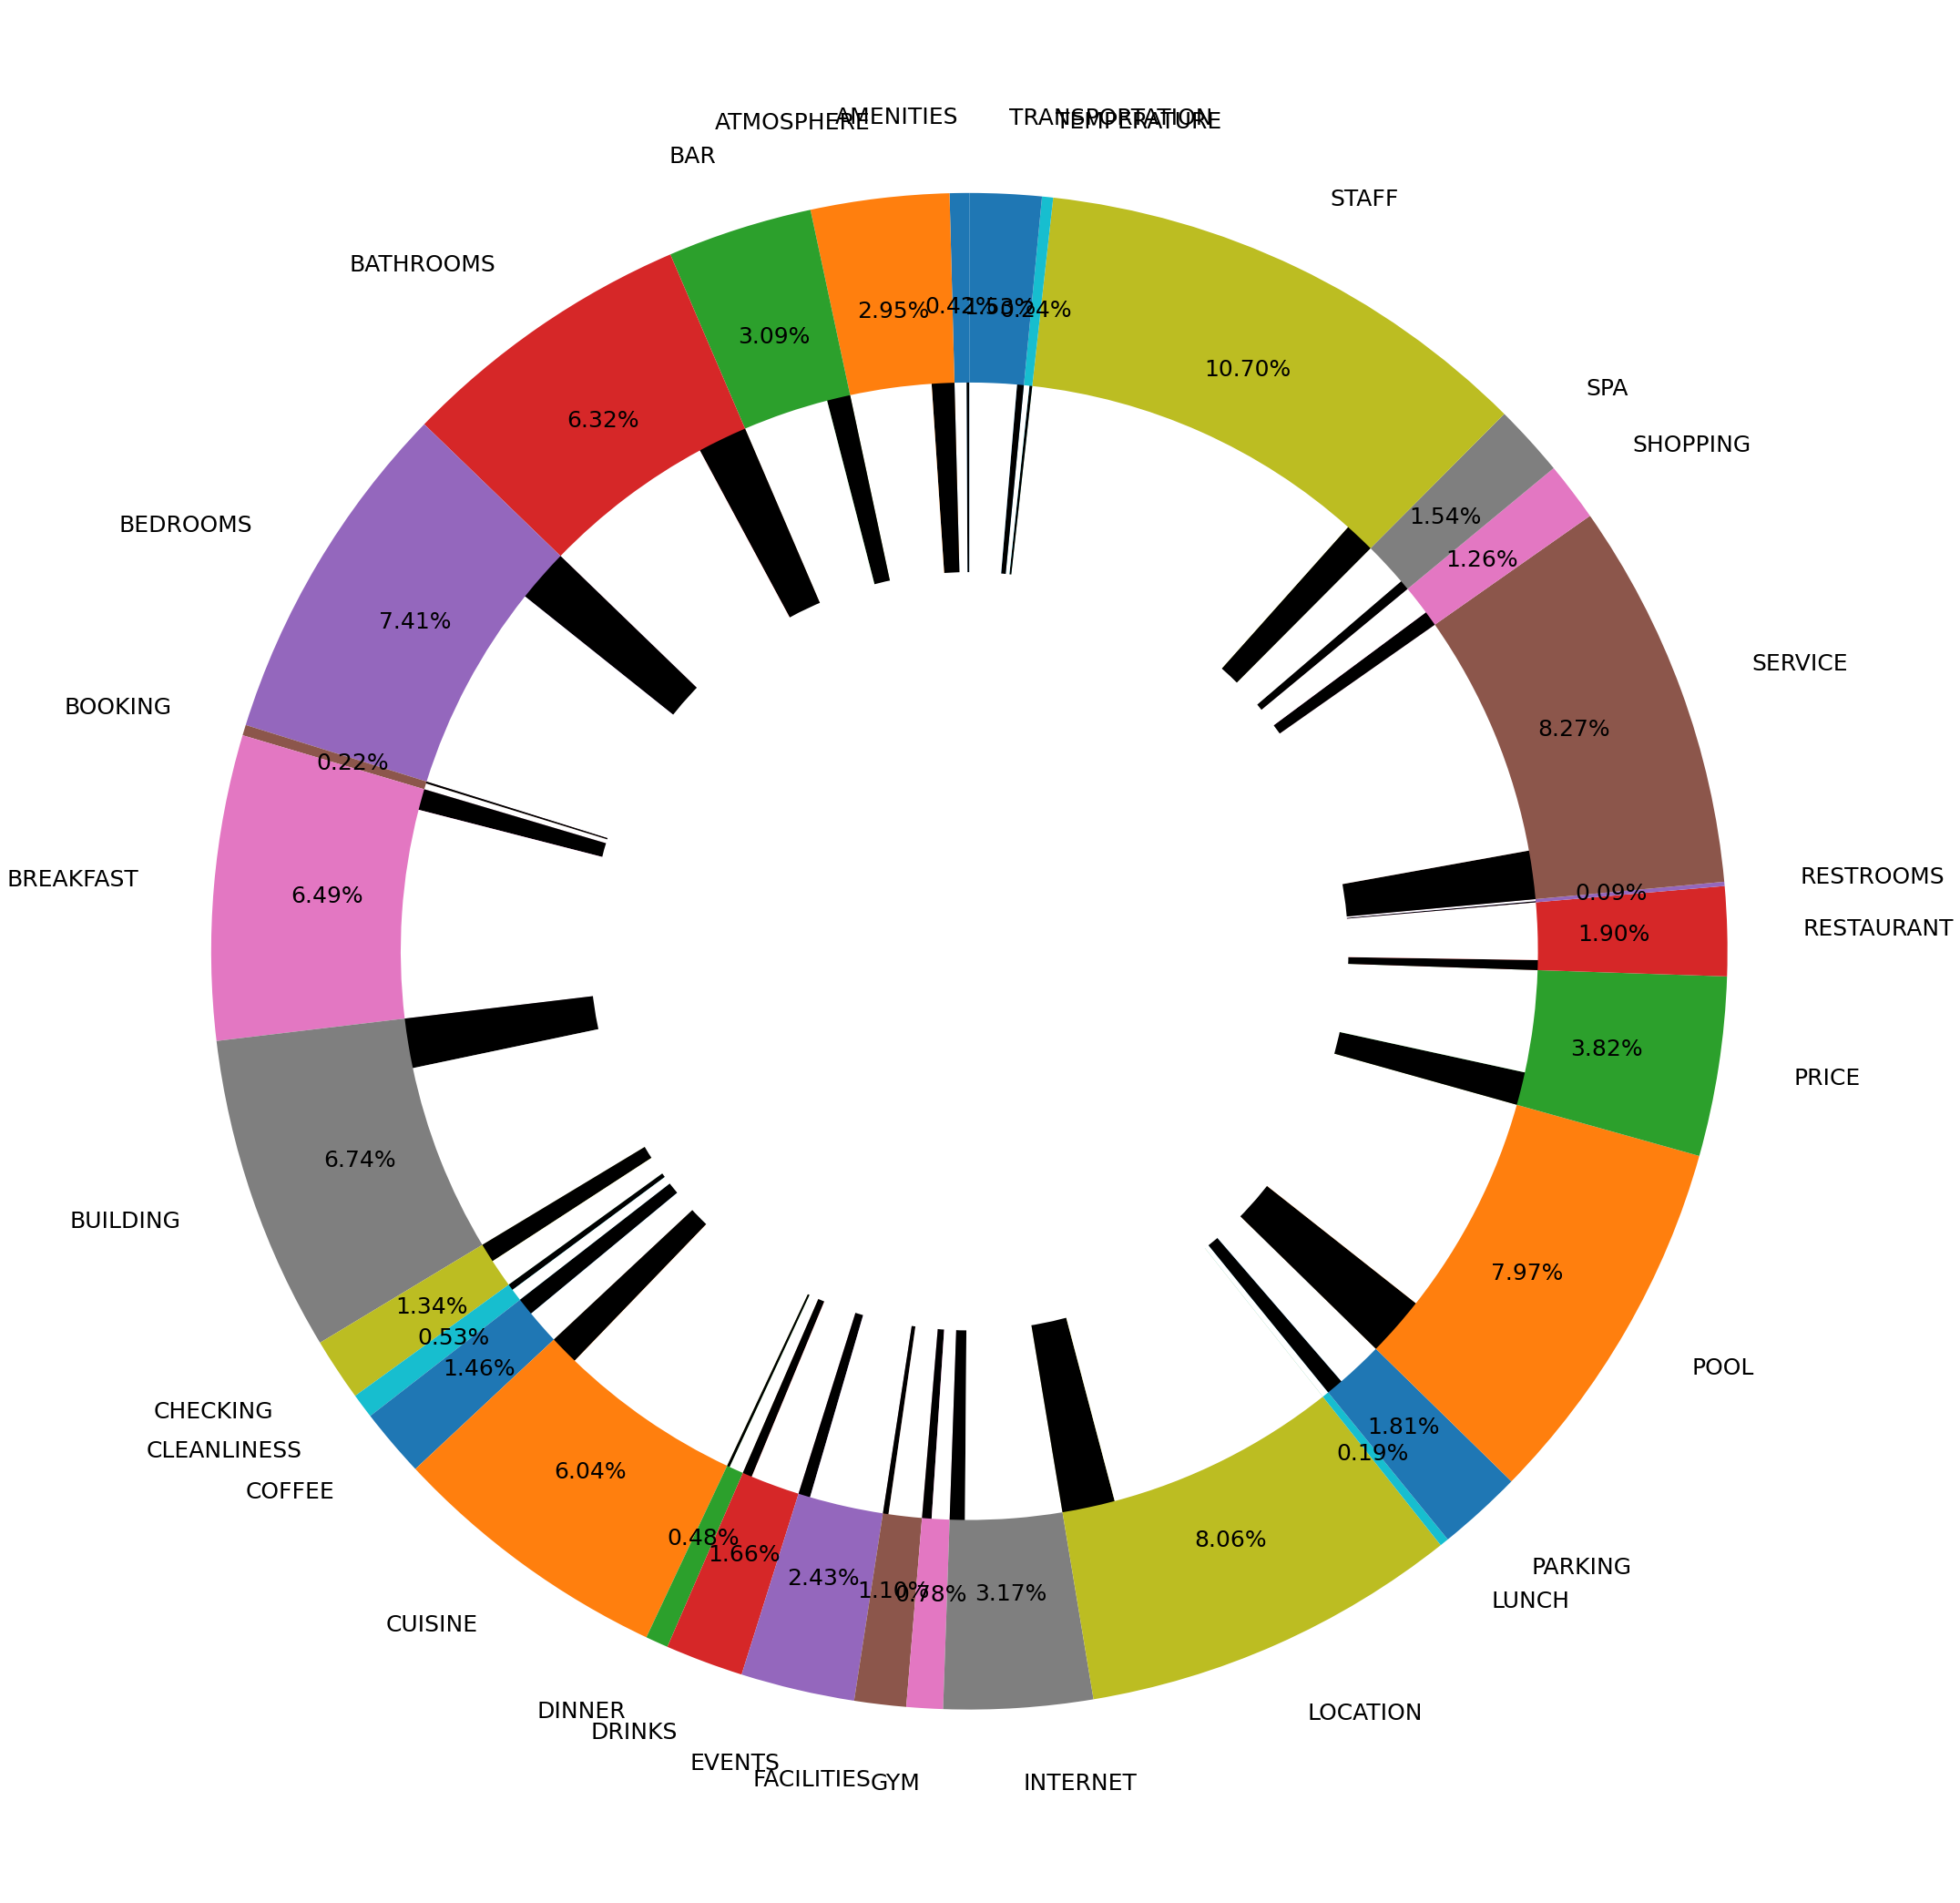

In [233]:
PAO.plot_pie(df_aspect_polarity)

The outer diagram represents the total number of opinions on each aspect, and the inner diagram shows the total number of positive (white) and negative (black) opinions for each aspect. We can see that the most relevant aspects are STAFF, BUILDING, SERVICE and POOL.

In [281]:
display(df_aspect_polarity.sort_values(by=['pos'], ascending = False)['pos'].to_frame().head().T)
display(df_aspect_polarity.sort_values(by=['neg'], ascending = False)['neg'].to_frame().head().T)
display((df_aspect_polarity.pos- df_aspect_polarity.neg).to_frame(name="pos >>> neg").sort_values(by=["pos >>> neg"], ascending = False).head().T)
display((df_aspect_polarity.pos- df_aspect_polarity.neg).to_frame(name="pos === neg").sort_values(by=["pos === neg"]).head().T)

aspect,STAFF,SERVICE,LOCATION,POOL,BEDROOMS
pos,875.0,614.0,584.0,558.0,525.0


aspect,POOL,BEDROOMS,LOCATION,BUILDING,BATHROOMS
neg,151.0,134.0,133.0,125.0,125.0


aspect,STAFF,SERVICE,BREAKFAST,LOCATION,POOL
pos >>> neg,798.0,492.0,471.0,451.0,407.0


aspect,RESTROOMS,TEMPERATURE,BOOKING,CLEANLINESS,LUNCH
pos === neg,2.0,7.0,10.0,15.0,17.0


In the tables above we can see that the aspects with the most positive comments are:

    STAFF SERVICE LOCATION POOL BEDROOMS
    
On the other hand, the aspects with the most negative opinions are:

    POOL BEDROOMS LOCATION BUILDING BATHROOMS
    
We see that POOL and LOCATION stand out for having both positive and negative opinions.
    
The third table shows the aspects that have a greater number of positive opinions compared to negative ones:

    STAFF SERVICE BREAKFAST LOCATION POOL
    
Therefore, we can conclude that Yelp hotels generally receive good reviews from STAFF, SERVICE, BREAKFAST, LOCATION, and POOL.

Finally, the last table shows those aspects for which the number of negative opinions is close to the number of positive opinions:

    RESTROOMS TEMPERATURE BOOKING CLEANLINESS LUNCH
    
Therefore, we can conclude that YELP hotels must improve these cleaning, temperature, booking and lunch services.




